# Import Packages / Load Data

In [30]:
# Imports
import pandas as pd
import numpy as np
import regex as re
import json,os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import scipy.stats as stats

In [31]:
# Load the data
df=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Q1. Do smokers have higher insurance charges than non-smokers?

Q2. Are men more likely to smoke than women?

Q3. Do different regions have different charges, on average?

# Do smokers have higher insurance charges than non-smokers?

Null Hypothesis: There is no significant difference in rates for smokers compared to non-smnokers.

Alternative Hypothesis: Rate for smokers is significantly different than non-smokers.

Siginificance Level: alpha = (.05)

In [33]:
df['smoker'].value_counts()


no     1064
yes     274
Name: smoker, dtype: int64

In [34]:
df_smoker = df.loc[df['smoker']=='yes']
df_smoker_non = df.loc[df['smoker']=='no']

# Visualize and Seperate Groups

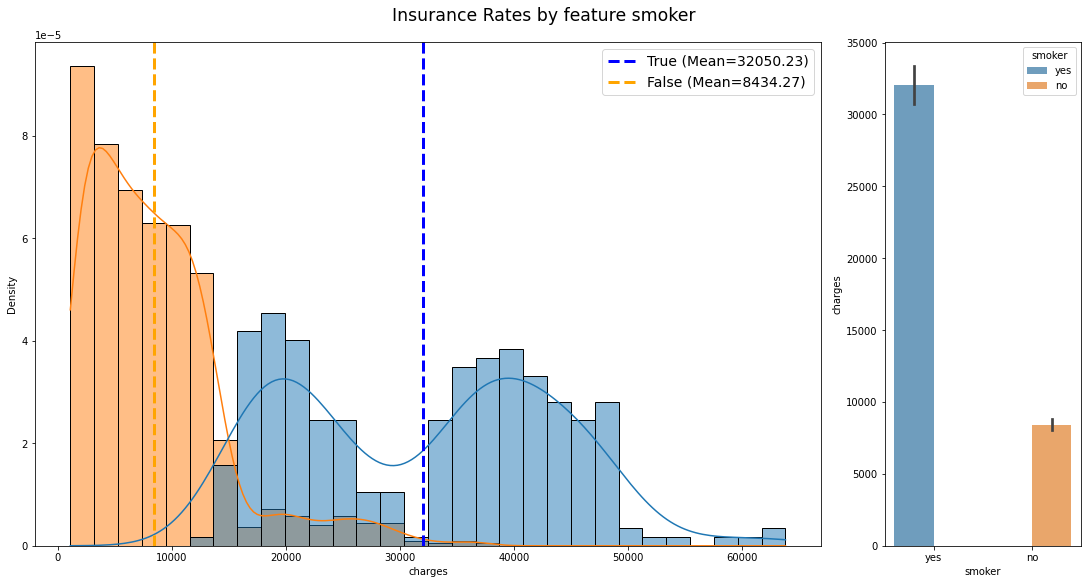

In [35]:
fig, (ax,ax2) = plt.subplots(figsize= (15,8),ncols=2,constrained_layout=True,
                            gridspec_kw={'width_ratios':[0.8,0.2]})
sns.histplot(data=df, x='charges',hue='smoker',kde=True,common_norm=False
                  ,stat='density',alpha=.5,hue_order=['yes','no'],ax=ax)
sns.barplot(data=df, x='smoker',y='charges',ax = ax2,hue='smoker',hue_order=['yes','no'],alpha=.7) 

ax.axvline(df_smoker['charges'].mean(), ls='--',lw=3, 
           label=f"True (Mean={df_smoker['charges'].mean():.2f})",color='blue')

ax.axvline(df_smoker_non['charges'].mean(), ls='--', lw=3, 
           label=f"False (Mean={df_smoker_non['charges'].mean():.2f})",color='orange')

ax.legend(prop={"size":14}, loc='upper right')
fig.suptitle('Insurance Rates by feature smoker',fontsize='xx-large');

T-Test

-Since we are comparing a numeric measurement between 2 groups, we want to run a 2-sample (AKA independent T-test).
    
    -No significant outliers
        
        -absolute value of zscore > 3

-Normality

-Equal Variance

No Significant outliers

In [36]:
# check for charge outliers by smoker for abs(zscore) > 3
idx_outliers = np.abs(stats.zscore(df_smoker['charges'])) > 3
idx_outliers.sum()

0

In [37]:
# check for charge outliers by smoker for abs(zscore) > 3
idx_outliers = np.abs(stats.zscore(df_smoker_non['charges'])) > 3
idx_outliers.sum()

24

Non-smoker has 24 outliers to remove

In [38]:
#remove outliers
display(df_smoker_non.shape)
df_smoker_non = df_smoker_non[(np.abs(stats.zscore(df_smoker_non['charges'])) < 3)]
display(df_smoker_non.shape)

(1064, 7)

(1040, 7)

# Check Normality for each group

In [39]:
# test Smokers normality
result_smoker = stats.normaltest(df_smoker['charges'])
result_smoker

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [40]:
# test Smokers normality
result_smoker_non = stats.normaltest(df_smoker_non['charges'])
result_smoker_non

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

P values for both groups well below alpha of .05; data is not normally distributed. Both sample sizes are above 15 per group so can move forward

# Check for Equal Variance

In [41]:
## use Levene's test to check if groups have equal variance
stats.levene(df_smoker['charges'],df_smoker_non['charges'])

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

P value well below .05. Do not have equal variances. need to set "equal_var = False" when we perform our t-test.

# Perform and evaluate the t-test

In [42]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(df_smoker['charges'], df_smoker_non['charges'], equal_var = False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

P value < alpha (0.05), reject the null hypothesis and accept that there is a significant difference between insurance rates for smokers vs non-smokers

# For Insurance carriers, are men more likely to smoke than women?

Null Hypothesis: For insurance carriers, there is no relationship between sex and if carrier smokes.

Alternative Hypothesis: Carriers sex has influence on if carrier smokes.

Siginificance Level: alpha = (.05)

# Visualize and Seperate Groups

In [43]:
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.0f%s' % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])
formatter = FuncFormatter(human_format)

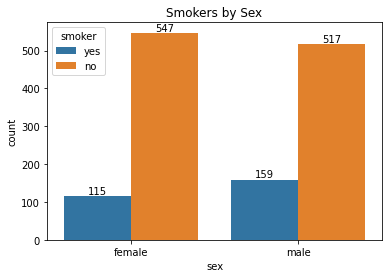

In [44]:
ax = sns.countplot(data=df, x='sex',hue='smoker')
ax.set_title("Smokers by Sex")
for container in ax.containers:
    labels = [  f'{human_format(x,1)}' for x in container.datavalues ]
    ax.bar_label(container,labels=labels)

# Chi-Squared

For comparing a binary target category vs categorical groups.

    -Put data from Smokers by sex into contingency table

In [45]:
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [46]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [47]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

P value for chi-squared <.05 reject null hypothesis. There is no relationship between sex and if insurance carrier is a smoker

# Do different regions have different charges, on average?

Null Hypothesis: There is no statistical difference in mean rate between regions.

Alternative Hypothesis: Statistically, region has influence on mean rates.

Siginificance Level: alpha = (.05)

In [48]:
df.groupby('region')['charges'].mean()

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64

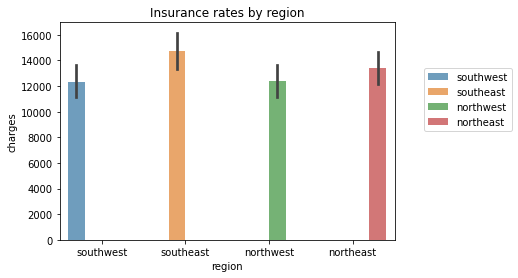

In [49]:
sns.barplot(data=df, x='region',y='charges',hue='region',alpha=.7 )
plt.legend(loc='lower right',bbox_to_anchor=(1.35,.5),borderaxespad=0)
plt.title("Insurance rates by region");

# Analysis of Variance (ANOVA)

In [50]:
## Create groups dictionary.
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

# Assumption of Normality

In [51]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


Each region has a normal distribution

# Outliers

In [52]:
# Drop outliers
for x in groups.keys():
    group_x = groups[x]
    outliers = np.abs(stats.zscore(group_x)) > 3    
    groups[x] = group_x[~outliers]
    print(x,':',len(groups[x]))

southwest : 317
southeast : 362
northwest : 318
northeast : 320


# Testing Assumption of Equal Variance

In [53]:
stats.levene(*groups.values())

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

Did not met the assumption of equal variance. For One-way ANOVA, will use Kruskal-Wallis stats.kruskal

In [54]:
result = stats.kruskal( *groups.values())
result

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)

The p-value for Kruskal-Wallis is > alpha of .05. Fail to reject null hypotheses. There is no significant difference between ranges for Insurance rates

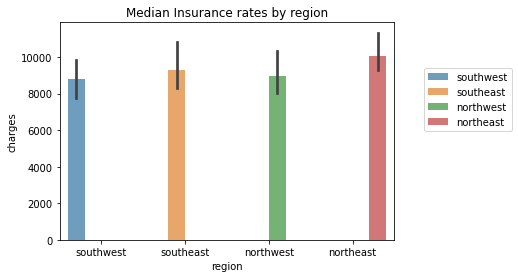

In [55]:
sns.barplot(data=df, x='region',y='charges',hue='region',alpha=.7 ,estimator = np.median)
plt.legend(loc='lower right',bbox_to_anchor=(1.35,.5),borderaxespad=0)
plt.title("Median Insurance rates by region");